# GRU model

## 1. Import data

In [122]:
import pandas as pd
import sys
import numpy as np

sys.path.append('/kaggle/input/utility-scripts')
from features import add_features

In [123]:
# Import datasets
train_series = pd.read_csv("/kaggle/input/input-data/filtered_train_series_continuous.csv")
test_series = pd.read_csv("/kaggle/input/input-data/filtered_test_series_continuous.csv")

In [124]:
# Add features
train_series = add_features(train_series)
test_series = add_features(test_series)

In [125]:
print(train_series.shape)
print(test_series.shape)

(787158, 40)
(204125, 40)


In [126]:
# Delete NAs
train_series = train_series.dropna()
test_series = test_series.dropna()
print(train_series.shape)
print(test_series.shape)

(786942, 40)
(204072, 40)


### Reshape the training data into 3D with SMOTE

So that it includes time windows (50 = ~7h)

In [127]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [128]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

def convert_to_3d(df, timestep_length=50, resample=True):
    # Ensure the DataFrame is sorted by series_id and step
    df = df.sort_values(by=["series_id", "step"])
        
    # Extract the events
    events = df["event"]
    # Remove the 'series_id' and 'events' column from the features
    features = df.drop(columns=["series_id", "event"])
    
    # SMOTE 
    smote = SMOTE(random_state=42)
    smote_series, smote_event = smote.fit_resample(features, events)
    
    if resample:
        # Split into train and eval
        X_train, X_val, Y_train, Y_val = train_test_split(smote_series, smote_event,
                                                         test_size=0.2, stratify=smote_event,
                                                         random_state=42)
        # Get the number of rows 
        num_rows_train = len(Y_train)
        num_rows_val = len(Y_val)
        # Truncate to the largest multiple of timestep_length
        num_rows_to_keep_train = num_rows_train - (num_rows_train % timestep_length)
        num_rows_to_keep_val = num_rows_val - (num_rows_val % timestep_length)

        # Reshape the events array
        reshaped_event_train = Y_train[:num_rows_to_keep_train].values.reshape(-1, timestep_length)
        reshaped_event_val = Y_val[:num_rows_to_keep_val].values.reshape(-1, timestep_length)
        # Reshape the dataframe into a 3D numpy array: (n_series, timesteps, features)
        reshaped_data_train = X_train[:num_rows_to_keep_train].values.reshape(-1, timestep_length, X_train.shape[1])
        reshaped_data_val = X_val[:num_rows_to_keep_val].values.reshape(-1, timestep_length, X_val.shape[1])
        return reshaped_data_train, reshaped_data_val, reshaped_event_train, reshaped_event_val
    
    # Get the number of rows in the SMOTE resampled events
    num_rows = len(smote_event)
    # Truncate to the largest multiple of timestep_length
    num_rows_to_keep = num_rows - (num_rows % timestep_length)
    
    # Reshape the events array
    reshaped_event = smote_event[:num_rows_to_keep].values.reshape(-1, timestep_length)
    # Reshape the dataframe into a 3D numpy array: (n_series, timesteps, features)
    reshaped_data = smote_series[:num_rows_to_keep].values.reshape(-1, timestep_length, smote_series.shape[1])
    
    return reshaped_data, reshaped_event

In [129]:
shaped_train_data, shaped_val_data, shaped_train_tar, shaped_val_tar = convert_to_3d(train_series)
shaped_test_data, shaped_test_tar = convert_to_3d(test_series, resample=False)

In [130]:
print("Train data:")
print(shaped_train_data.shape)
print(shaped_train_tar.shape, "\n")
print("Eval data:")
print(shaped_val_data.shape)
print(shaped_val_tar.shape, "\n")
print("Test data:")
print(shaped_test_data.shape)
print(shaped_test_tar.shape)

Train data:
(37423, 50, 38)
(37423, 50) 

Eval data:
(9355, 50, 38)
(9355, 50) 

Test data:
(12121, 50, 38)
(12121, 50)


In [131]:
# Calculate class weights
unique, counts = np.unique(shaped_train_tar, return_counts=True)
weights = counts.sum()/counts
print(weights)

[3.00001283 2.99998397 3.00000321]


### One hot encoding

In [132]:
import keras

In [133]:
shaped_train_target = keras.utils.to_categorical(shaped_train_tar)
shaped_val_target = keras.utils.to_categorical(shaped_val_tar)
shaped_test_target = keras.utils.to_categorical(shaped_test_tar)

In [134]:
print("One hot encoded targets:")
print(shaped_train_target.shape)
print(shaped_val_target.shape)
print(shaped_test_target.shape)

One hot encoded targets:
(37423, 50, 3)
(9355, 50, 3)
(12121, 50, 3)


## 2. Build and run model

In [135]:
# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import GRU, Dense, Input, Bidirectional, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve


### Home-made loss function

In [136]:
def weighted_categorical_crossentropy(weights):
    
    weights = K.variable(weights)

    def loss(y_true, y_pred):
        """Calculate weighted categorical crossentropy loss."""
        # Clip predictions to avoid log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        # Calculate unweighted categorical crossentropy
        cce = y_true * K.log(y_pred)
        
        # Multiply with weights for each class
        weighted_cce = cce * weights
        
        # Take mean across timesteps and batch dimensions
        return -K.mean(K.sum(weighted_cce, axis=-1))  # sum across classes, mean across batch and timesteps

    return loss

### Build and train the model

In [137]:
def find_optimal_threshold(test_target_classes, test_pred, num_classes=3):
    thresholds = np.arange(0.1, 0.9, 0.01)  # Range of thresholds to search
    best_thresholds = []
    best_f1_scores = []
    
    # Loop through each class to find the best threshold for maximizing F1 score
    for i in range(num_classes):
        f1_scores = []
        for threshold in thresholds:
            # Binarize predictions using the threshold
            binary_pred = (test_pred[:, i] >= threshold).astype(int)
            binary_true = (test_target_classes == i).astype(int)

            # Compute F1 score
            f1 = f1_score(binary_true, binary_pred, zero_division=1)
            f1_scores.append(f1)

        # Get the best threshold for this class
        best_idx = np.argmax(f1_scores)
        best_thresholds.append(thresholds[best_idx])
        best_f1_scores.append(f1_scores[best_idx])

        print(f"Class {i} - Best Threshold: {best_thresholds[-1]}, Best F1 Score: {best_f1_scores[-1]}")
    
    return best_thresholds, best_f1_scores

In [138]:
def build_gru_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(GRU(units=128, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(GRU(units=64, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(GRU(units=32, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Dense(units=3, activation='softmax'))
    
    return model


def train_gru_model(X_train, Y_train,
                    X_val, Y_val,
                    class_weights):
    
    # Ensure data is in the correct numerical format
    X_train = np.array(X_train, dtype=np.float32)
    Y_train = np.array(Y_train, dtype=np.int32)
    X_val = np.array(X_val, dtype=np.float32)
    Y_val = np.array(Y_val, dtype=np.int32)

    # Define the input shape for the GRU model
    input_shape = X_train.shape[1:]
    
    # Build and compile the GRU model
    model = build_gru_model(input_shape)
    model.compile(loss=weighted_categorical_crossentropy(class_weights), 
                  optimizer='adam', metrics=['accuracy', 'precision'])

    # Define early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(x=X_train, y=Y_train, batch_size=64,
                        validation_data=(X_val, Y_val),
                        epochs=20, callbacks=[early_stop])

    # Evaluate the model on the validation set
    test_pred = model.predict(X_val).reshape(-1, 3)
    test_target_classes = np.argmax(Y_val.reshape(-1, 3), axis=1)

    # Find optimal thresholds for each class
    best_thresholds, _ = find_optimal_threshold(test_target_classes, test_pred)

    # Apply the optimal thresholds to get final predictions
    final_pred_classes = []
    for i in range(len(best_thresholds)):
        # Binarize predictions using the optimal thresholds
        binary_pred = (test_pred[:, i] >= best_thresholds[i]).astype(int)
        final_pred_classes.append(binary_pred)

    # Combine final predictions for each class
    final_pred_classes = np.array(final_pred_classes).T  # Shape: (num_samples, num_classes)
    
    # Get the predicted class based on the maximum value across the classes
    final_pred_classes = np.argmax(final_pred_classes, axis=1)

    # Calculate precision, accuracy, recall, and F1-score
    precision = precision_score(test_target_classes, final_pred_classes, average='macro')
    accuracy = accuracy_score(test_target_classes, final_pred_classes)
    recall = recall_score(test_target_classes, final_pred_classes, average='macro')
    f1 = f1_score(test_target_classes, final_pred_classes, average='macro')

    # Save the metrics for this fold
    metrics = {
        'precision': precision,
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1
    }
    
    return model, metrics

In [139]:
model, metrics = train_gru_model(shaped_train_data, shaped_train_target,
                                 shaped_val_data, shaped_val_target,
                                 weights)

Epoch 1/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.4395 - loss: 3.2287 - precision: 0.4890 - val_accuracy: 0.5044 - val_loss: 2.9999 - val_precision: 0.5835
Epoch 2/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.4941 - loss: 3.0419 - precision: 0.5592 - val_accuracy: 0.5166 - val_loss: 2.9389 - val_precision: 0.5812
Epoch 3/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5036 - loss: 3.0074 - precision: 0.5676 - val_accuracy: 0.5509 - val_loss: 2.8202 - val_precision: 0.6161
Epoch 4/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5149 - loss: 2.9656 - precision: 0.5761 - val_accuracy: 0.5092 - val_loss: 2.9716 - val_precision: 0.5854
Epoch 5/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5123 - loss: 2.9701 - precision: 0.5753 - val_accuracy: 0.5279 - val_loss: 2.8951 - val_precision: 0.6029
Epoch 6/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5157 - loss: 2.9522 - precision: 0.5800 - val_accuracy: 0.5359

In [140]:
model.save("model_GRU.keras")

### Plot the results

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

#### Confusion matrix

In [151]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics

def plot_confusion_matrix(model, x_test, y_test):
    # Generate predictions
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=-1)
    y_test_classes = np.argmax(y_test, axis=-1)

    # Flatten the predictions and true labels
    y_pred_classes_flat = y_pred_classes.flatten()
    y_test_classes_flat = y_test_classes.flatten()

    # Compute the confusion matrix
    confusion_mtx = sklearn.metrics.confusion_matrix(y_test_classes_flat, y_pred_classes_flat, normalize="true")

    # Set up the matplotlib figure
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    # Create the heatmap
    heatmap = sns.heatmap(confusion_mtx, annot=True, fmt=".2f", cmap="Blues", square=True)

    # Customize the axes and titles
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Show the plot
    plt.tight_layout()
    plt.show()


379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


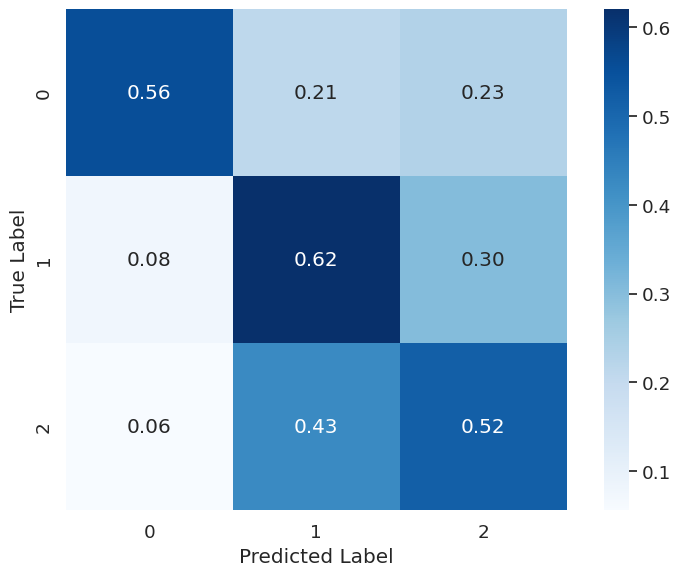

In [152]:
plot_confusion_matrix(model, shaped_test_data, shaped_test_target)

### K-fold validation

In [144]:
def train_gru_model_with_kfold(series, target, class_weights, k=3):
    
    # Ensure data is in the correct numerical format
    series = np.array(series, dtype=np.float32)
    target = np.array(target, dtype=np.int32)

    # Initialize the KFold cross-validator
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    histories = []
    fold_metrics = []

    # Perform K-Fold cross-validation
    for fold, (train_idx, test_idx) in enumerate(kf.split(series)):
        print(f"\nTraining fold {fold + 1}/{k}...")

        # Split the data into train and validation sets
        train_series, test_series = series[train_idx], series[test_idx]
        train_target, test_target = target[train_idx], target[test_idx]

        # Train the GRU model
        model, metrics = train_gru_model(train_series, train_target, test_series, test_target, class_weights)

        # Save the history and model for this fold
        histories.append(model.history)

        # Save metrics for this fold
        fold_metrics.append(metrics)

    return histories, fold_metrics

In [ ]:
histories, fold_metrics = train_gru_model_with_kfold(shaped_train_data, shaped_train_target, weights)

#### Metrics

In [ ]:
def print_fold_metrics_summary(fold_metrics):
    # Convert fold_metrics (list of dicts) into a DataFrame
    metrics_df = pd.DataFrame(fold_metrics)
    
    # Calculate mean and standard error for each metric
    summary_df = pd.DataFrame({
        'Metric': ['accuracy', 'precision', 'recall', 'f1_score'],
        'Mean': [
            metrics_df['accuracy'].mean(),
            metrics_df['precision'].mean(),
            metrics_df['recall'].mean(),
            metrics_df['f1_score'].mean()
        ],
        'Standard Error': [
            metrics_df['accuracy'].std() / np.sqrt(len(metrics_df)),
            metrics_df['precision'].std() / np.sqrt(len(metrics_df)),
            metrics_df['recall'].std() / np.sqrt(len(metrics_df)),
            metrics_df['f1_score'].std() / np.sqrt(len(metrics_df))
        ]
    })

    # Print the summary table
    print(summary_df.to_string(index=False))


def print_overall_metrics(metrics):
    # Specify the desired order of metrics
    metric_order = ['accuracy', 'precision', 'recall', 'f1_score']
    # Create a DataFrame from the metrics dictionary
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
    # Reindex the DataFrame to ensure the desired order
    metrics_df = metrics_df.reindex(metric_order)
    # Print the metrics table
    print(metrics_df.to_string(index=True, header=False))

In [ ]:
print_fold_metrics_summary(fold_metrics)

In [ ]:
print_overall_metrics(metrics)